<a href="https://colab.research.google.com/github/lbhargav/Machine-Learning-Mercari-Price-Suggestion-Kaggle-Challenge-/blob/master/KaggleMercariCompetitionWithEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Mercari, Japan’s biggest community-powered shopping app, they’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, the challenge is to build an algorithm that automatically suggests the right product prices. We are provided with user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

About the data
1.5 million observations in the training data Column name

1. name - text
2. item description - text
3. item condition id categorical - ordinal 5
4. category name text/categorical
5. brand name text/categorical
6. shipping boolean
7. price - continuos(target)


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import sys
import time
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [9]:
# Load Data
start_time = time.time()
df=pd.read_table('/content/train.tsv','\t')
test_df=pd.read_table('/content/test_stg2.tsv','\t')
print('[{}] Finished to load data'.format(time.time() - start_time))
print('Train shape: ', df.shape)
print('Test shape: ', test_df.shape)
train_len = df.shape[0]

[3.9492244720458984] Finished to load data
Train shape:  (525810, 8)
Test shape:  (528209, 7)


In [10]:
# target varible
target = df['price']
target.head(5)

0    10.0
1    52.0
2    10.0
3    35.0
4    44.0
Name: price, dtype: float64

In [11]:
# data set size and preliminary information about data
df_copy = df.copy(deep=True)
print(df.shape)
display(df.info())

(525810, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525810 entries, 0 to 525809
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           525810 non-null  int64  
 1   name               525810 non-null  object 
 2   item_condition_id  525810 non-null  int64  
 3   category_name      523557 non-null  object 
 4   brand_name         301573 non-null  object 
 5   price              525810 non-null  float64
 6   shipping           525810 non-null  int64  
 7   item_description   525809 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 32.1+ MB


None

In [12]:
# check for null values
print(df.apply(lambda x: sum(x.isnull()), axis=0))

train_id                  0
name                      0
item_condition_id         0
category_name          2253
brand_name           224237
price                     0
shipping                  0
item_description          1
dtype: int64


'Missing Values as a Percentage of Total Records'

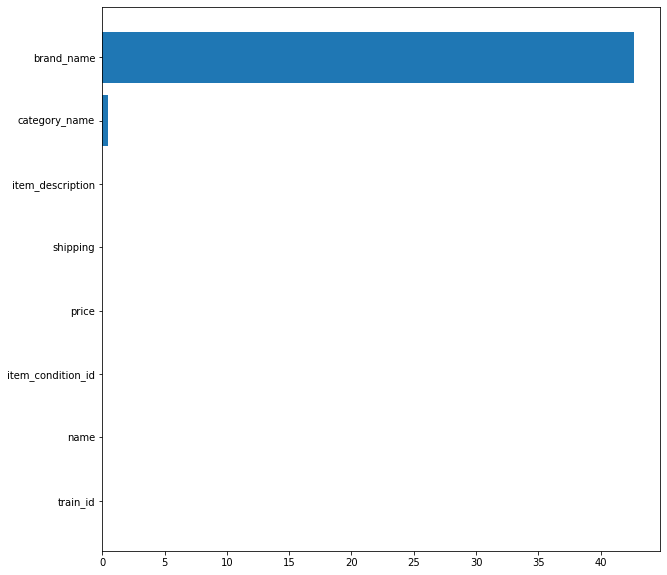

In [13]:
# missing values as graph
display('Missing Values as a Percentage of Total Records')
# horizontal bar chart percentage
fig = plt.figure()
fig.set_size_inches(10, 10)
df_mv = pd.DataFrame({'columns':df.columns ,'mv_percent':df.isnull().sum()/len(df)*100})
df_mv.sort_values('mv_percent',inplace=True)
mv_barh = plt.barh(df_mv['columns'],width=df_mv['mv_percent']);
plt.show()

In [14]:
# handling missing values for brand_name and item_description
def fill_missing_values(dataframe):
    """
    Function to handle missing values
    :param df: dataframe
    """
    dataframe['brand_name'].fillna(value='no brand', inplace=True)
    dataframe['item_description'].fillna(value='no description', inplace=True)

fill_missing_values(df)
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no brand,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no brand,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no brand,44.0,0,Complete with certificate of authenticity


In [15]:
# derive new features
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

# splitting category column into three sub categories
df['general_cat'], df['sub_cat1'], df['sub_cat2']= zip(*df['category_name'].apply(lambda x: split_cat(x)))
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no brand,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no brand,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no brand,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [16]:
category_names = ['general_cat', 'sub_cat1', 'sub_cat2']
for category in category_names:
    print("There are %d unique values in %s." % (df[category].nunique(), category))

There are 11 unique values in general_cat.
There are 114 unique values in sub_cat1.
There are 824 unique values in sub_cat2.


Women                     235733
Beauty                     73910
Kids                       60619
Electronics                43450
Men                        33238
Home                       24208
Vintage & Collectibles     16563
Other                      16117
Handmade                   10850
Sports & Outdoors           8869
No Label                    2253
Name: general_cat, dtype: int64

'general_cat'

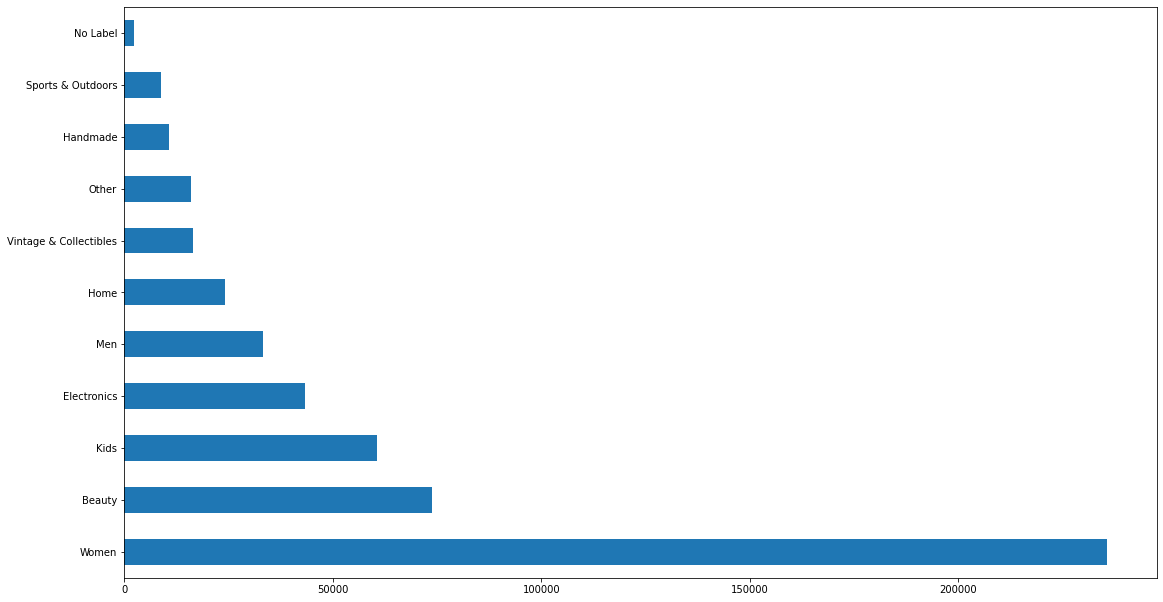

In [17]:
display(df['general_cat'].value_counts())
display('general_cat')
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
t1 = pd.value_counts(df['general_cat'].values,sort=True)
t1.plot.barh()
plt.locator_params(axis='y')
plt.show()

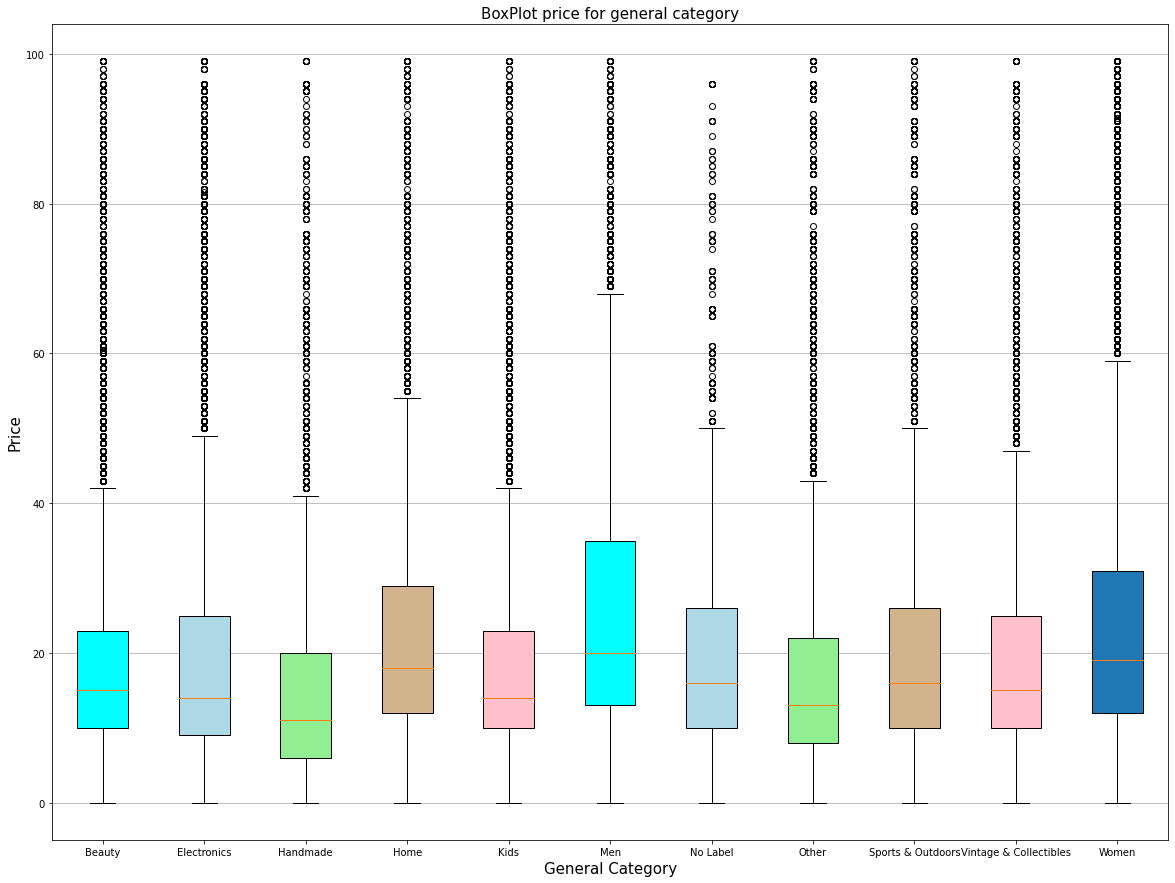

In [18]:
general_cat_labels = df['general_cat'].astype('category').cat.categories.tolist()
general_cat_labels

df_category = df[df['price']<100]

my_plot = []
for i in general_cat_labels:
    my_plot.append(df_category[df_category['general_cat']==i]['price'])
    
fig, axes = plt.subplots(figsize=(20, 15))
bp = axes.boxplot(my_plot,vert=True,patch_artist=True,labels=general_cat_labels) 

colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink']*2
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes.yaxis.grid(True)

plt.title('BoxPlot price for general category', fontsize=15)
plt.xlabel('General Category', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

In [19]:
target.describe()

count    525810.000000
mean         26.699236
std          38.494017
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2000.000000
Name: price, dtype: float64

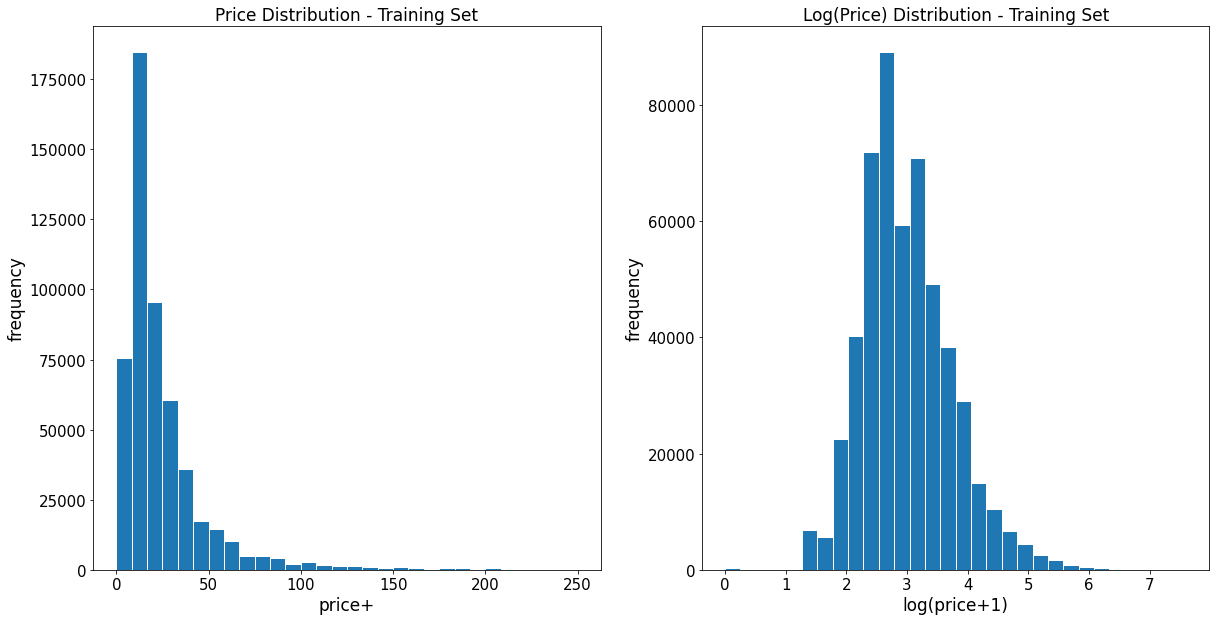

In [20]:
plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=30, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(df['price']+1).plot.hist(bins=30, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

As we can observe from the left side graph, 'price' is skewed towards right. So, we applied log tranfomation to get normal distribution.

### Preliminary EDA Conclusions:

* Brand has more than 40% missing values. So, we imputed the missing brand values with 'no_brand'.
* Derived new features 'general_cat', 'sub_cat1', 'sub_cat2' from Category.
* Applied log transformation on price.

In [21]:
del df
gc.collect()

11711

In [22]:
#  Encoding feature values
def encoding(dataframe):
    """
    Function to encode the dataset features
    :param df: dataframe
    """
    lb_make = LabelEncoder()
    dataframe['brand_name_encoded'] = lb_make.fit_transform(dataframe['brand_name'])
    dataframe['sub_cat1_encoded'] = lb_make.fit_transform(dataframe['sub_cat1'])
    dataframe['sub_cat2_encoded'] = lb_make.fit_transform(dataframe['sub_cat2'])
    pd.concat([dataframe['brand_name_encoded'],dataframe['sub_cat1_encoded'],dataframe['sub_cat2_encoded']], axis=1, sort=False)

#  One-hot-encoding feature values
def one_hot_encoding(dataframe):
    """
    Function to encode the dataset features
    :param df: dataframe
    """
    one_hot_encoded_features = pd.get_dummies(dataframe[['item_condition_id', 'shipping','general_cat']], columns = ['item_condition_id', 'shipping','general_cat'],
                                      prefix_sep = '_', drop_first = False)
    
    return one_hot_encoded_features

#  Tf-idf vectorization
def get_tfidf_vectorizer(dataframe, col):
    """
    Function to get tf-idf matrix for given text data
    :param df: dataframe
    """
    tfidf_vectorizer = TfidfVectorizer(max_features = 5,
                     ngram_range = (1, 2),
                     stop_words = 'english')
    return pd.DataFrame(tfidf_vectorizer.fit_transform(dataframe[col]).toarray(), 
                                  columns = tfidf_vectorizer.get_feature_names())

In [23]:
full_data = pd.concat([df_copy, test_df], ignore_index=True)
full_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet,NaN
1,1.0,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,NaN
2,2.0,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,NaN
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,NaN
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0.0,Complete with certificate of authenticity,NaN


### Text Processing¶
There are two features with text description:

1. item-description: concatenated the item_description, name, and category_name to get information of a product.
2. name: concatenated the name feature with brand name.


Applied Tf-idf for name and item_description features. Tf-idf is the acronym for Term Frequency–inverse Document Frequency.
It quantifies the importance of a particular word in relative to the vocabulary of a collection of documents or corpus. 
It normalizes the text data.

In [24]:
def preprocess_text():
    full_data['name'] = full_data['name'].fillna('') + ' ' + full_data['brand_name'].fillna('')
    full_data['item_description'] = (full_data['item_description'].fillna('') + ' ' + full_data['name'] + ' ' + full_data['category_name'].fillna(''))
preprocess_text()
full_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet MLB Cincinnati Reds T Shirt...,NaN
1,1.0,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,NaN
2,2.0,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,NaN
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,NaN
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0.0,Complete with certificate of authenticity 24K ...,NaN


In [25]:
# splitting category column into three sub categories
full_data['general_cat'], full_data['sub_cat1'], full_data['sub_cat2']= zip(*full_data['category_name'].apply(lambda x: split_cat(x)))

In [26]:
#Capturing NAN values with a new feature¶
full_data['brand_NAN']=np.where(full_data['brand_name'].isnull(),1,0)
full_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id,general_cat,sub_cat1,sub_cat2,brand_NAN
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet MLB Cincinnati Reds T Shirt...,NaN,Men,Tops,T-shirts,1
1,1.0,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,NaN,Electronics,Computers & Tablets,Components & Parts,0
2,2.0,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,NaN,Women,Tops & Blouses,Blouse,0
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,NaN,Home,Home Décor,Home Décor Accents,1
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0.0,Complete with certificate of authenticity 24K ...,NaN,Women,Jewelry,Necklaces,1


In [27]:
fill_missing_values(full_data)

In [28]:
print("The number of different brands: " + str(full_data.brand_name.nunique()))

The number of different brands: 4412


Performing one-hot encoding on brand would introduce the curse of dimensionality. So, we perform one hot encoding for the top 20  frequent brands.

In [29]:
full_data.brand_name.value_counts().sort_values(ascending=False).head(20)
top_brands=list(full_data.brand_name.value_counts().sort_values(ascending=False).head(20).index)[1:]
print("Top 20 brands: " + str(top_brands))

Top 20 brands: ['PINK', 'Nike', "Victoria's Secret", 'LuLaRoe', 'Apple', 'Nintendo', 'FOREVER 21', 'Lululemon', 'Michael Kors', 'American Eagle', 'Rae Dunn', 'Sephora', 'Disney', 'Coach', 'Adidas', 'Bath & Body Works', 'Funko', 'Under Armour', 'Sony']


In [30]:
def encode_for_top_brands(dataframe, top_brands):
    for brand in top_brands:
        dataframe[brand]=np.where(dataframe['brand_name']==brand,1,0)  
        
encode_for_top_brands(full_data, top_brands)
full_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id,general_cat,sub_cat1,sub_cat2,brand_NAN,PINK,Nike,Victoria's Secret,LuLaRoe,Apple,Nintendo,FOREVER 21,Lululemon,Michael Kors,American Eagle,Rae Dunn,Sephora,Disney,Coach,Adidas,Bath & Body Works,Funko,Under Armour,Sony
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no brand,10.0,1.0,No description yet MLB Cincinnati Reds T Shirt...,NaN,Men,Tops,T-shirts,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,NaN,Electronics,Computers & Tablets,Components & Parts,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.0,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,NaN,Women,Tops & Blouses,Blouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no brand,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,NaN,Home,Home Décor,Home Décor Accents,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no brand,44.0,0.0,Complete with certificate of authenticity 24K ...,NaN,Women,Jewelry,Necklaces,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
encoding(full_data)
                     
full_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,test_id,general_cat,sub_cat1,sub_cat2,brand_NAN,PINK,Nike,Victoria's Secret,LuLaRoe,Apple,Nintendo,FOREVER 21,Lululemon,Michael Kors,American Eagle,Rae Dunn,Sephora,Disney,Coach,Adidas,Bath & Body Works,Funko,Under Armour,Sony,brand_name_encoded,sub_cat1_encoded,sub_cat2_encoded
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no brand,10.0,1.0,No description yet MLB Cincinnati Reds T Shirt...,NaN,Men,Tops,T-shirts,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4394,103,749
1,1.0,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...,NaN,Electronics,Computers & Tablets,Components & Parts,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3247,30,208
2,2.0,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...,NaN,Women,Tops & Blouses,Blouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3832,104,92
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no brand,35.0,1.0,New with tags. Leather horses. Retail for [rm]...,NaN,Home,Home Décor,Home Décor Accents,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4394,55,392
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no brand,44.0,0.0,Complete with certificate of authenticity 24K ...,NaN,Women,Jewelry,Necklaces,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4394,58,523


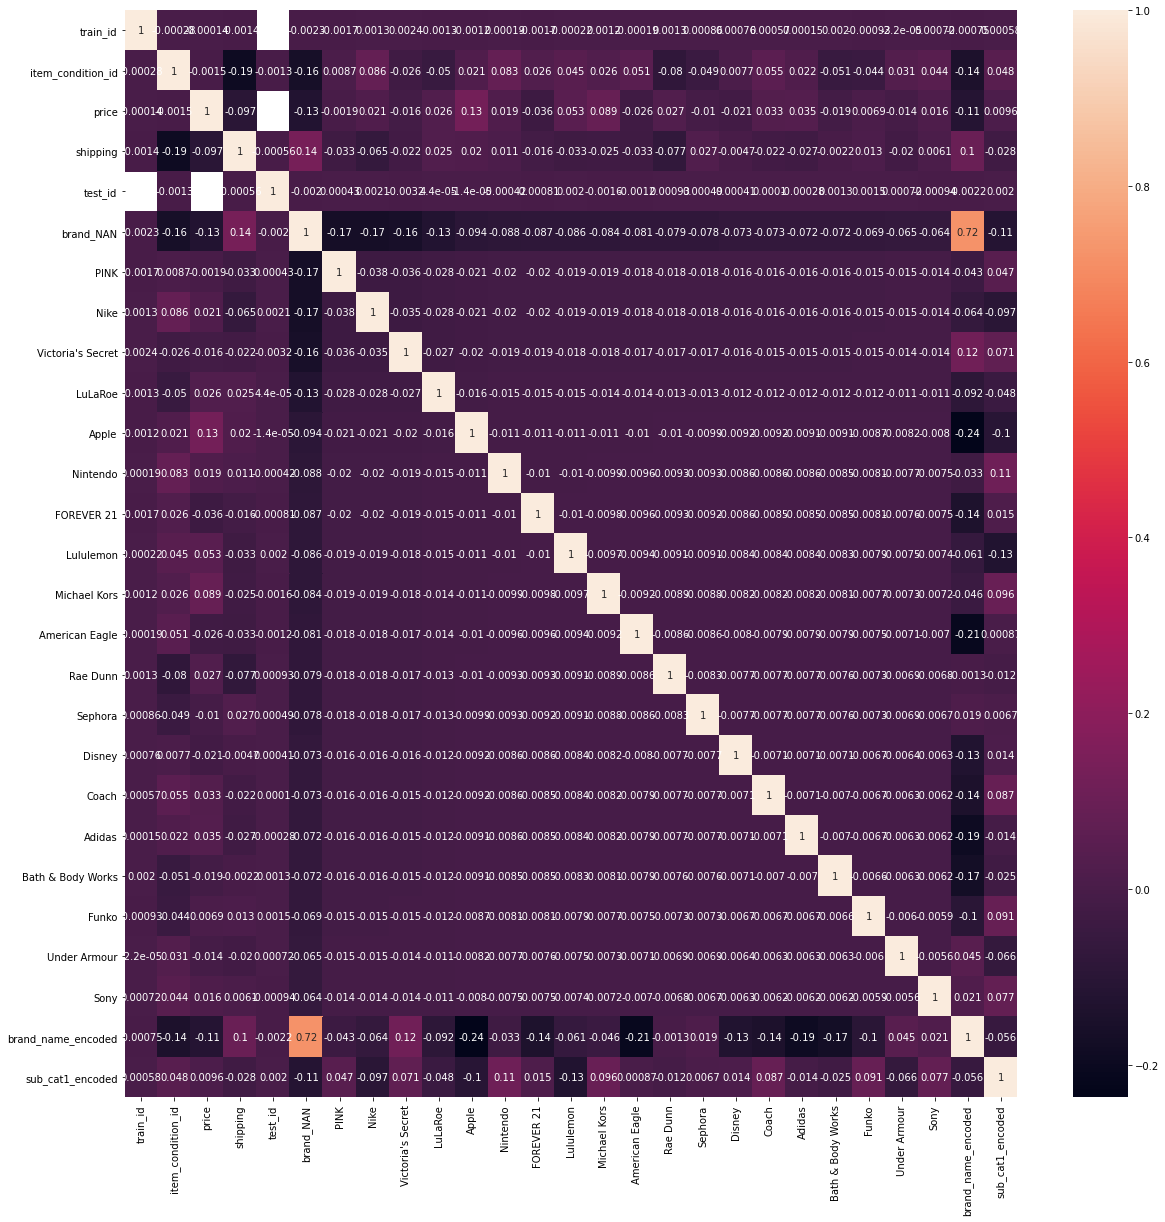

In [32]:
import seaborn as sns
corr=full_data.iloc[:,:-1].corr()
top_features=corr.index
plt.figure(figsize=(20,20))
sns.heatmap(full_data[top_features].corr(),annot=True)

In [33]:
full_data = pd.concat([full_data, get_tfidf_vectorizer(full_data, 'item_description')], axis = 1)
full_data = pd.concat([full_data, get_tfidf_vectorizer(full_data, 'name')], axis = 1)

In [34]:
full_data.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'test_id', 'general_cat',
       'sub_cat1', 'sub_cat2', 'brand_NAN', 'PINK', 'Nike',
       'Victoria's Secret', 'LuLaRoe', 'Apple', 'Nintendo', 'FOREVER 21',
       'Lululemon', 'Michael Kors', 'American Eagle', 'Rae Dunn', 'Sephora',
       'Disney', 'Coach', 'Adidas', 'Bath & Body Works', 'Funko',
       'Under Armour', 'Sony', 'brand_name_encoded', 'sub_cat1_encoded',
       'sub_cat2_encoded', 'brand', 'free', 'new', 'size', 'women', 'lularoe',
       'nike', 'pink', 'secret', 'victoria'],
      dtype='object')

In [35]:
Y = np.log1p(full_data.price[:train_len])
print(Y.shape)

(525810,)


In [36]:
full_data.drop(['train_id', 'category_name', 'price', 'item_description', 'name', 'test_id', 'item_condition_id', 'brand_name', 'general_cat', 'sub_cat1', 'sub_cat2'], axis=1, inplace=True)
full_data.head(4)

,shipping,brand_NAN,PINK,Nike,Victoria's Secret,LuLaRoe,Apple,Nintendo,FOREVER 21,Lululemon,Michael Kors,American Eagle,Rae Dunn,Sephora,Disney,Coach,Adidas,Bath & Body Works,Funko,Under Armour,Sony,brand_name_encoded,sub_cat1_encoded,sub_cat2_encoded,brand,free,new,size,women,lularoe,nike,pink,secret,victoria
0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4394,103,749,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3247,30,208,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3832,104,92,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4394,55,392,0.0,0.795547,0.605892,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X = full_data[:train_len]
X_test = full_data[train_len:]
del full_data

gc.collect()

43

In [38]:
train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=144)
d_train = lgb.Dataset(train_sparse_matrix, label=y_train)
params = {
    'learning_rate': 0.15,
    'application': 'regression',
    'max_depth': 15,
    'num_leaves': 400,
    'verbosity': -1,
    'metric': 'RMSE',
    'data_random_seed': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.6,
}
regressor = lgb.train( params, train_set=d_train, num_boost_round=3200, verbose_eval=100)
predictions= regressor.predict(valid_sparse_matrix)

pred=[]
for prediction in predictions:
    if prediction<0:
        prediction=0
    pred.append(float(prediction))
predNP=np.array(pred)
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))
print(rmsle(y_valid, predNP))

0.14505601252187203


In [39]:
print("predictions on test data")
submission: pd.DataFrame = test_df[['test_id']]
test_pred = regressor.predict(X_test)
preds=[]
for prediction in test_pred:
    if prediction<0:
        prediction=0
    preds.append(float(prediction))
predNP = np.array(preds)
submission['price'] = np.expm1(predNP)
# submission.to_csv("submission.csv", index=False)
# print("submission done")

predictions on test data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



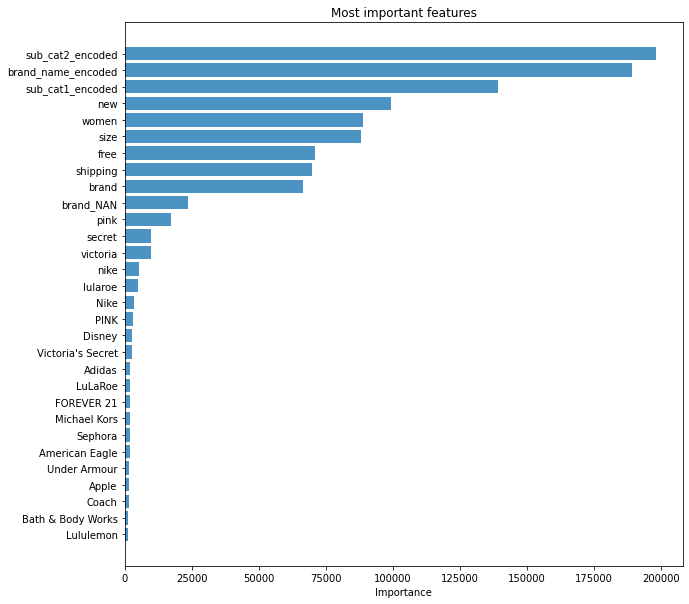

In [40]:
# Create list of top most features based on importance
feature_names = train_sparse_matrix.columns
feature_imports = regressor.feature_importance()
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(30, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,10))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=10)
plt.xlabel('Importance')
plt.title('Most important features')
plt.show()